# Digit Recognizer

This is for Kaggle's [Digit Recognizer competition](https://www.kaggle.com/competitions/digit-recognizer)

This approach is based off of Andrew Ng's Neural Networks and Deep Learning course in the [Deep Learning specialization on Coursera](https://www.coursera.org/specializations/deep-learning); however, it has been adapted for this particular problem.

This approach includes a implementation of a deep neural network utilizing numpy.

In [131]:
import numpy as np
import pandas as pd
import copy

In [132]:
def data_prep(raw, num_classes=10):
    """
    Argument:
    raw -- The raw data rad from a csv file
    num_classes -- The number of labels

    Returns:
    x -- Normalized
    y_one_hot -- One-hot encoding of labels
    """
    data = np.array(raw)
    m, n = data.shape
    print("data.shape = (m = {0}, n = {1})".format(m, n))
    
    # Extract labels and feature set
    y = data[:, 0]
    X = data[:, 1:] / 255
    
    # Transpose X to match the expected shape (number_of_features, number_of_examples)
    X = X.T
    
    # Convert labels to one-hot encoding
    y_one_hot = np.zeros((m, num_classes))
    y_one_hot[np.arange(m), y] = 1

    # Transpose y_one_hot to match the expected shape (number_of_classes, number_of_examples)
    y_one_hot = y_one_hot.T
    
    print("X.shape = {0}".format(X.shape))
    print("y_one_hot.shape = {0}".format(y_one_hot.shape))
    
    return X, y_one_hot

In [133]:
def relu(Z):
    """
    Implements the ReLU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    A = np.maximum(0, Z)
    cache = Z  
    assert (A.shape == Z.shape)
    
    return A, cache

In [134]:
def softmax(Z):
    """
    For multi-class classification.

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- Softmax output, same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    # subtract the maximum of Z from each Z before applying exp to stabilize the computation.
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    A = np.exp(Z_shifted) / np.sum(np.exp(Z_shifted), axis=0, keepdims=True)
    assert (A.shape == Z_shifted.shape)
    cache = A
    
    return A, cache

In [135]:
def initialize_parameters(layer_dims):
    """
    Initialze using the He initialization method.
    
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
        Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
        bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(0)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(1. / layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [136]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [137]:
def linear_activation_forward(A_prev, W, b, activation=''):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "softmax" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
                stored for computing the backward pass efficiently
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
        
    match activation:
        case "softmax":
            A, activation_cache = softmax(Z)
        case "relu":
            A, activation_cache = relu(Z)
        case _:
            assert (False)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [138]:
def forward_prop(X, parameters):
    """
    Implement forward propagation

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters()

    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2  # Dividing by 2 because parameters include W and b for each layer
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
    
    # Implement LINEAR -> SOFTMAX for the last layer.
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='softmax')
    caches.append(cache)
          
    return AL, caches


In [153]:
def compute_cost(AL, Y, type='cross-entropy'):
    """
    Implement the cost function.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector, shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    
    match type:
        case 'mse':
            # Implement the Mean Squared Error (MSE) cost function
            cost = (1 / m) * np.sum((AL - Y) ** 2)
        case 'cross-entropy':
            # Compute the cross-entropy cost with epsilon to avoid log(0)
            epsilon = 1e-9
            cost = -np.sum(Y * np.log(AL + epsilon)) / m
        case _:
            assert (False)
    
    cost = np.squeeze(cost)  # To make sure the cost's shape is what we expect.

    return cost

In [140]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [141]:
def softmax_backward(AL, Y, cache):
    """
    Implements the backward propagation for a single softmax unit.

    Arguments:
    AL -- post-activation output from the softmax layer, of shape (number of classes, number of examples)
    Y -- true "label" vector, same shape as AL
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = AL - Y
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [142]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [143]:
def linear_activation_backward(dA, Y, cache, activation):
    """
    Implements the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "softmax" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    match activation:
        case "softmax":
            dZ = softmax_backward(dA, Y, activation_cache)
            dA_prev, dW, db = linear_backward(dZ, linear_cache)
        case "relu":
            dZ = relu_backward(dA, activation_cache)
            dA_prev, dW, db = linear_backward(dZ, linear_cache)
        case _:
            assert (False)
        
    return dA_prev, dW, db

In [144]:
def back_prop(AL, Y, caches):
    """
    Implement the backward propagation

    Arguments:
    AL -- probability vector, output of the forward propagation
    Y -- true "label" vector
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "softmax" (it's caches[L-1])

    Returns:
    grads -- A dictionary with the gradients
        grads["dA" + str(l)] = ... 
        grads["dW" + str(l)] = ...
        grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    epsilon = 1e-9 # to avoid division by zero
    dAL = -(np.divide(Y, AL + epsilon) - np.divide(1 - Y, 1 - AL + epsilon))
    
    # Lth layer gradients.
    current_cache = caches[-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, Y, current_cache, activation='softmax')
    grads["dA" + str(L - 1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], Y, current_cache, activation='relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [145]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent.

    Arguments:
    params -- python dictionary containing the parameters 
    grads -- python dictionary containing the gradients, output of backwards propagation

    Returns:
    parameters -- python dictionary containing the updated parameters 
        parameters["W" + str(l)] = ... 
        parameters["b" + str(l)] = ...
    """
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [146]:
def model(X, Y, layers_dims, initial_learning_rate=0.01, decay=10, decay_interval=50, num_iterations=500, print_cost=True):
    """
    Implements a L-layer neural network

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    decay -- The learning rate decay
    decay_interval -- Specifies on this iteration the decay is applied to the learning rate
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    costs -- cost values over time
    """
    costs = []
    learning_rate = initial_learning_rate
    
    # Parameters initialization.
    parameters = initialize_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Learning rate decay by factor of decay for every decay_interval iterations
        if i > 0 and i % decay_interval == 0:
            learning_rate /= decay
        
        AL, caches = forward_prop(X, parameters)
        cost = compute_cost(AL, Y, type='mse')
        grads = back_prop(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every decay_interval iterations
        if print_cost and i % 25 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            print("learning_rate after iteration {}: {}".format(i, learning_rate))
            
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

# Using the custom deep neural network

## Read data from CSV

In [147]:
filepath = '/kaggle/input/digit-recognizer/train.csv'
raw_data = pd.read_csv(filepath)
raw_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prepare the data

In [148]:
X, y = data_prep(raw_data)

data.shape = (m = 42000, n = 785)
X.shape = (784, 42000)
y_one_hot.shape = (10, 42000)


## Define the model

In [158]:
# Hyperparameters defining the model
layers_dims = [len(X), 10]
learning_rate_init = 0.01
learning_rate_decay = 10
learning_rate_decay_interval = 225
num_iterations = 250

# Generate the model
parameters, costs = model(X=X,
                          Y=y,
                          layers_dims=layers_dims,
                          initial_learning_rate=learning_rate_init,
                          decay=learning_rate_decay,
                          decay_interval=learning_rate_decay_interval,
                          num_iterations=num_iterations,
                          print_cost=True)

Cost after iteration 0: 1.8054447418320307
learning_rate after iteration 0: 0.01
Cost after iteration 25: 1.2658746608212943
learning_rate after iteration 25: 0.01
Cost after iteration 50: 0.9558928380599668
learning_rate after iteration 50: 0.01
Cost after iteration 75: 0.775010709090833
learning_rate after iteration 75: 0.01
Cost after iteration 100: 0.6669521556078212
learning_rate after iteration 100: 0.01
Cost after iteration 125: 0.599403322476835
learning_rate after iteration 125: 0.01
Cost after iteration 150: 0.5535807366258934
learning_rate after iteration 150: 0.01
Cost after iteration 175: 0.5209816623938733
learning_rate after iteration 175: 0.01
Cost after iteration 200: 0.4974661788079457
learning_rate after iteration 200: 0.01
Cost after iteration 225: 0.48059481443897467
learning_rate after iteration 225: 0.001
Cost after iteration 249: 0.47927914053149817
learning_rate after iteration 249: 0.001


## Predict on training set

In [159]:
def predict_train_data(X, y, parameters):
    """
    This function is used to predict the results of a L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    y -- true "label" vector (one-hot encoded)
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2

    # Forward propagation
    AL, caches = forward_prop(X, parameters)

    # Convert predictions and true labels to categorical form
    predictions = np.argmax(AL, axis=0)
    true_labels = np.argmax(y, axis=0)

    # Calculate accuracy
    accuracy = np.sum(predictions == true_labels) / m

    # Print results
    print("Accuracy: " + str(accuracy * 100) + '%')

    return predictions

# Make the predicitons on training data set
pred_train = predict_train_data(X, y, parameters)

Accuracy: 83.71190476190476%


## Predict using test set and plot some random predictions

In [160]:
def prepare_test_data(raw):
    """
    Prepares test data (without labels)

    Arguments:
    raw -- raw test data read from a csv file

    Returns:
    X -- normalized test data
    """
    X = np.array(raw) / 255
    X = X.T  # Transpose to match the expected shape (number_of_features, number_of_examples)
    
    print("X_test.shape =", X.shape)
    
    return X

def predict_test_data(X, parameters):
    """
    This function is used to predict the results of a L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2

    # Forward propagation
    AL, caches = forward_prop(X, parameters)

    # Convert predictions to categorical form
    predictions = np.argmax(AL, axis=0)

    return predictions

# Read and prepare test data
filepath = '/kaggle/input/digit-recognizer/test.csv'
raw_test_data = pd.read_csv(filepath)
X_test = prepare_test_data(raw_test_data)

# Make the predicitons on test data set
pred_test = predict_test_data(X_test, parameters)

X_test.shape = (784, 28000)


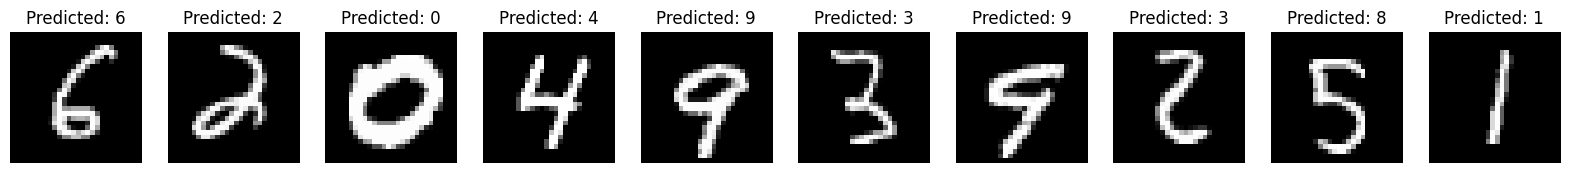

In [164]:
import matplotlib.pyplot as plt

def plot_images_with_predictions(X, predictions, num_images=10):
    """
    Plots a random selection of images with their predicted labels.

    Arguments:
    X -- dataset of shape (number_of_features, number_of_examples)
    predictions -- array of predicted labels for the dataset
    num_images -- number of random images to display
    """
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    
    for i, ax in enumerate(axes):
        # Randomly select an image
        idx = np.random.randint(X.shape[1])
        img = X[:, idx].reshape(28, 28)  # Reshape the image to 28x28

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Predicted: {predictions[idx]}')
        ax.axis('off')

    plt.show()

# Plot images with predictions
plot_images_with_predictions(X_test, pred_test)

## Create file of predictions for submission

In [162]:
# Create a DataFrame with ImageId and Label
result_df = pd.DataFrame({
    'ImageId': range(1, len(pred_test) + 1),
    'Label': pred_test
})

# Save to CSV
filename = "submission.csv"
result_df.to_csv(filename, index=False)

print(f'Saved predictions to {filename}')


Saved predictions to submission.csv
